<center><h1>N.N. Bach</h1></center>
<center><i>Generating Music in the Syle of J.S. Bach Using LSTM Nets</i></center>
<center><img src="bach-nn-half.jpg"></center><br>

## Introduction
This notebook attempts to generate monophonic music in the style of Johann Sebastian Bach. It will do so by utilizing Long short-term memory (LSTM) RNN's. 

The input of this network will be a single MIDI file, and the output will be a new MIDI file, generated by the network, in a style similar to the input piece.

Below is a brief overview of this process:

![](midi.png)

Once the MIDI is generated, it is converted to a wav file via wildmidi.

## Imports
In this notebook music21, an open-source music library written by MIT will be used to read and create MIDI files. Keras will be used to process the MIDI data and generate new pieces of music. Additionaly matplotlib will be used to plot various graphs.

Below these elements are imported:

In [3]:
import os
from music21 import converter, corpus, instrument, midi, note, chord, pitch, stream
import numpy as np
import keras
from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical 
from matplotlib import pyplot
import IPython.display as ipd

Using TensorFlow backend.


## Load the data
Firstly, a MIDI file is read, converting the contents to a music21 "stream" object. This converts the binary data of the MIDI file into an easy readable format. Due to a lack of computational resources, only one piece at a time will be used in this notebook. 

For this notebook, Bach's Contrapunctus I from The Art of Fugue will be used:

In [2]:
def readMidi(filename):
    mf = midi.MidiFile()
    mf.open(filename)
    mf.read()
    mf.close()
    return midi.translate.midiFileToStream(mf)

midiTrack = readMidi("bach.mid")

## Visualise the piece
The extracted MIDI data consists of a stream of note data, each containing multiple "parts". A part represents a single monophonic pattern of notes. Below frequencies of each note of each stream are extracted, and plotted in a visualisation. We begin by extracting the freqency data from the piece:

In [3]:
def createFreqArray(track):
    returnArray = []
    for i in range(0, len(track.parts)):
        tmpArray = []
        section = track.parts[i].flat.notes  
        for thisNote in section:
            if isinstance(thisNote, note.Note):
                pitch = str(thisNote.pitch.frequency)
                tmpArray.append(pitch)
        returnArray.append(tmpArray)
    return returnArray

freqPattern = createFreqArray(midiTrack)

Then proceed to plot these frequencies onto a graph:

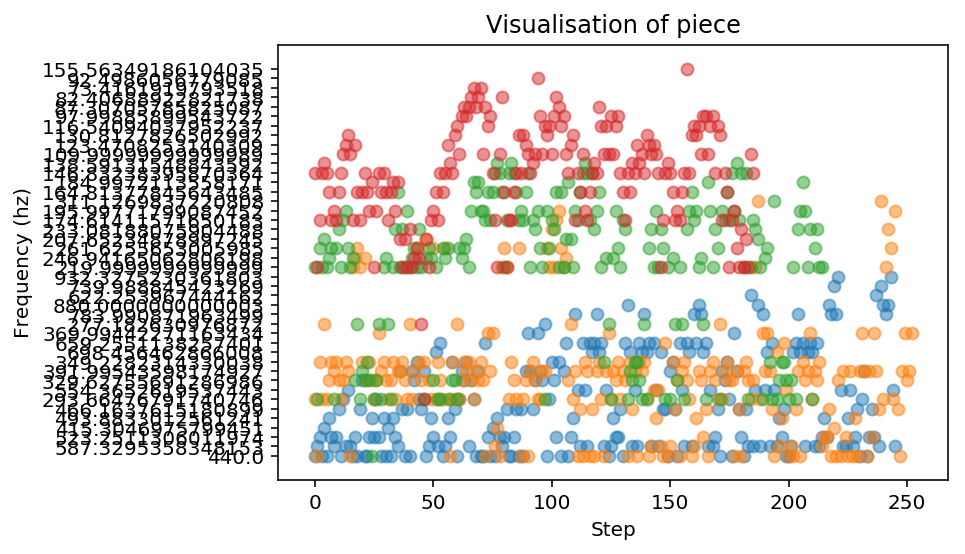

In [4]:
def visualiseFreqArray(array):
    for i in range(len(array)):
        x = range(len(array[i]))
        y = array[i]
        pyplot.scatter(x, y, alpha=0.5)
    pyplot.title("Visualisation of piece")
    pyplot.ylabel("Frequency (hz)")
    pyplot.xlabel("Step")
    pyplot.show()
    
visualiseFreqArray(freqPattern)

## Create note and note duration arrays
Sequences of note names and the duration of each note are extracted into arrays in order to further examine these parameters.
In order to obtain every note in the piece of music, a function is needed that loops through each part, then, loops through each note of the part. Since we are only going to be generating monophonic music, each part's notes is concatenated to a long array, read to be processed.
 
Two functions are created, one for extracting each feature (Note and duration) from the MIDI stream:

In [5]:
# For extracting notes
def createNoteArray(track):
    returnArray = []
    for i in range(0, len(track.parts)):
        section = track.parts[i].flat.notes  
        for thisNote in section:
            if isinstance(thisNote, note.Note):
                pitch = str(thisNote.pitch)
                returnArray.append(pitch)
    return returnArray

# For extracting durataion data
def createDurationArray(track):
    returnArray = []
    for i in range(len(track.parts)):
        section = track.parts[i].flat.notes  
        for thisNote in section:
            if isinstance(thisNote, note.Note):
                dur = str(thisNote.duration.quarterLength)
                returnArray.append(dur)
    return returnArray

notePattern = createNoteArray(midiTrack)
durationPattern = createDurationArray(midiTrack)

## One hot encode the data
In order to feed the data into the network it needs to be encoded. This is done via one-hot encoding, for both the note and duration data:

In [6]:
noteDict = {}
durationDict = {}
encodedNote = []
encodedDuration = []

def encodeNote(data, dict):
    returnCode = 0
    if data not in dict:
        returnCode = len(dict)
        dict[data] = returnCode
    else:
        returnCode = dict[data]
    return returnCode

# Encode note data
for rawNote in notePattern:
    encodedNote.append(encodeNote(rawNote, noteDict))

# Encode duration data
for rawDur in durationPattern:
    encodedDuration.append(encodeNote(rawDur, durationDict))

## Split the data
In order to train the network a dataset must be created from the encoded data. This dataset will consist of two parts: The training data and the training labels. 

In order to create the training data patterns of note and duration of $n$ length are taken from the encoded data, with a stride of one each time. The label data is simply the note or duration which directly follows the pattern. This can be seen below:

In [7]:
def createData(encodedData, dictLen):
    sequenceLen = dictLen
    x = []
    y = []
    for i in range(0, len(encodedData) - sequenceLen):
        thisX = encodedData[i:i + sequenceLen]
        x.append(thisX)
        thisY = encodedData[i + sequenceLen]
        y.append(thisY)
    x = np.reshape(x, (len(x), sequenceLen, 1))
    y = to_categorical(y)
    return x, y


xNote, yNote = createData(encodedNote, len(noteDict))
xDuration, yDuration = createData(encodedDuration, len(durationDict))

## Create the models
Two models need to be created. Multiclass classification will be performed on two sets of data: Note values, and note durations. As both of these are sequence data which rely heavily on previous values, a LSTM layer is used to first process the data. Next, the output will be fed into a dense layer which outputs a prediction of which catagory the pattern input should corrispond with. Since this is multiclass classifcation the catagorical crossentropy loss function shall be used:

In [8]:
# Model for notes
noteModel = keras.models.Sequential()
noteModel.add(layers.LSTM(128, input_shape=(xNote.shape[1], xNote.shape[2])))
noteModel.add(layers.Dense(len(yNote[0]), activation='softmax'))
noteModel.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# Model for note duration
durationModel = keras.models.Sequential()
durationModel.add(layers.LSTM(128, input_shape=(xDuration.shape[1], xDuration.shape[2])))
durationModel.add(layers.Dense(len(yDuration[0]), activation='softmax'))
durationModel.compile(loss='categorical_crossentropy', optimizer='rmsprop')

## Train
The two models need to be trained. They are both trained for 250 epochs and their history is recorded.

In [9]:
print("==Training note model==")
noteModelHistory = noteModel.fit(xNote, yNote, epochs=250)
print("==Training duration model==")
durationModelHistory = durationModel.fit(xDuration, yDuration, epochs=250)

==Training note model==
Epoch 1/250
858/858 [==============================] - 5s 6ms/step - loss: 3.2931
Epoch 2/250
858/858 [==============================] - 4s 4ms/step - loss: 2.9366
Epoch 3/250
858/858 [==============================] - 4s 4ms/step - loss: 2.8253
Epoch 4/250
858/858 [==============================] - 4s 4ms/step - loss: 2.7674
Epoch 5/250
858/858 [==============================] - 4s 4ms/step - loss: 2.6963
Epoch 6/250
858/858 [==============================] - 4s 4ms/step - loss: 2.6589
Epoch 7/250
858/858 [==============================] - 4s 4ms/step - loss: 2.6276
Epoch 8/250
858/858 [==============================] - 4s 4ms/step - loss: 2.6295
Epoch 9/250
858/858 [==============================] - 4s 4ms/step - loss: 2.5885
Epoch 10/250
858/858 [==============================] - 4s 4ms/step - loss: 2.5634
Epoch 11/250
858/858 [==============================] - 4s 4ms/step - loss: 2.5522
Epoch 12/250
858/858 [==============================] - 4s 4ms/step - lo

858/858 [==============================] - 3s 4ms/step - loss: 0.6333
Epoch 197/250
858/858 [==============================] - 3s 4ms/step - loss: 0.6060
Epoch 198/250
858/858 [==============================] - 3s 4ms/step - loss: 0.6559
Epoch 199/250
858/858 [==============================] - 3s 4ms/step - loss: 0.6299
Epoch 200/250
858/858 [==============================] - 3s 4ms/step - loss: 0.6084
Epoch 201/250
858/858 [==============================] - 3s 4ms/step - loss: 0.5981
Epoch 202/250
858/858 [==============================] - 3s 4ms/step - loss: 0.6231
Epoch 203/250
858/858 [==============================] - 3s 4ms/step - loss: 0.5644
Epoch 204/250
858/858 [==============================] - 4s 4ms/step - loss: 0.6006
Epoch 205/250
858/858 [==============================] - 3s 4ms/step - loss: 0.5896
Epoch 206/250
858/858 [==============================] - 3s 4ms/step - loss: 0.5725
Epoch 207/250
858/858 [==============================] - 3s 4ms/step - loss: 0.5748
Epoch 

Epoch 44/250
886/886 [==============================] - 1s 2ms/step - loss: 1.0873
Epoch 45/250
886/886 [==============================] - 1s 2ms/step - loss: 1.0815
Epoch 46/250
886/886 [==============================] - 1s 2ms/step - loss: 1.0781
Epoch 47/250
886/886 [==============================] - 1s 1ms/step - loss: 1.0673
Epoch 48/250
886/886 [==============================] - 1s 2ms/step - loss: 1.0606
Epoch 49/250
886/886 [==============================] - 1s 2ms/step - loss: 1.0603
Epoch 50/250
886/886 [==============================] - 1s 2ms/step - loss: 1.0471
Epoch 51/250
886/886 [==============================] - 1s 2ms/step - loss: 1.0457
Epoch 52/250
886/886 [==============================] - 1s 2ms/step - loss: 1.0369
Epoch 53/250
886/886 [==============================] - 1s 2ms/step - loss: 1.0257
Epoch 54/250
886/886 [==============================] - 1s 2ms/step - loss: 1.0234
Epoch 55/250
886/886 [==============================] - 2s 2ms/step - loss: 1.0144
Epoc

886/886 [==============================] - 1s 2ms/step - loss: 0.0421
Epoch 240/250
886/886 [==============================] - 1s 2ms/step - loss: 0.0602
Epoch 241/250
886/886 [==============================] - 1s 2ms/step - loss: 0.0524
Epoch 242/250
886/886 [==============================] - 2s 2ms/step - loss: 0.0423
Epoch 243/250
886/886 [==============================] - 2s 2ms/step - loss: 0.0922
Epoch 244/250
886/886 [==============================] - 2s 2ms/step - loss: 0.0417
Epoch 245/250
886/886 [==============================] - 2s 2ms/step - loss: 0.0439
Epoch 246/250
886/886 [==============================] - 1s 2ms/step - loss: 0.0741
Epoch 247/250
886/886 [==============================] - 1s 2ms/step - loss: 0.0437
Epoch 248/250
886/886 [==============================] - 2s 2ms/step - loss: 0.0411
Epoch 249/250
886/886 [==============================] - 1s 2ms/step - loss: 0.0676
Epoch 250/250
886/886 [==============================] - 1s 2ms/step - loss: 0.0364


## Check loss
The loss of each model is plotted in order to see how the training has progressed:

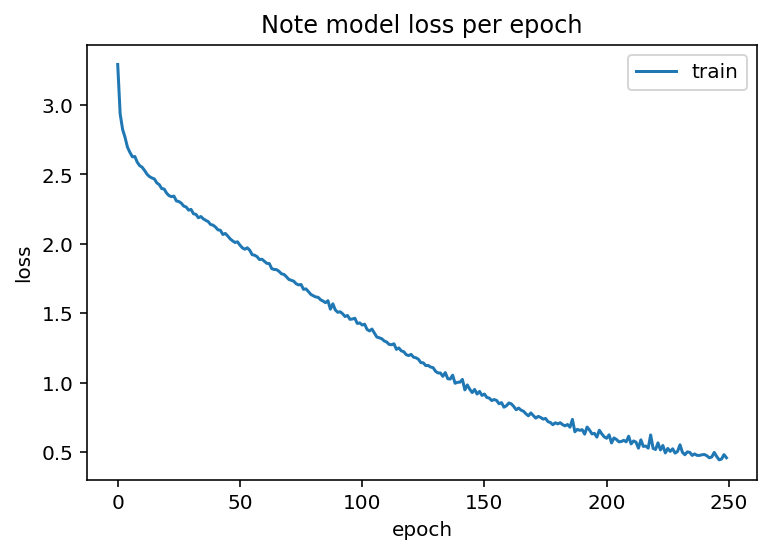

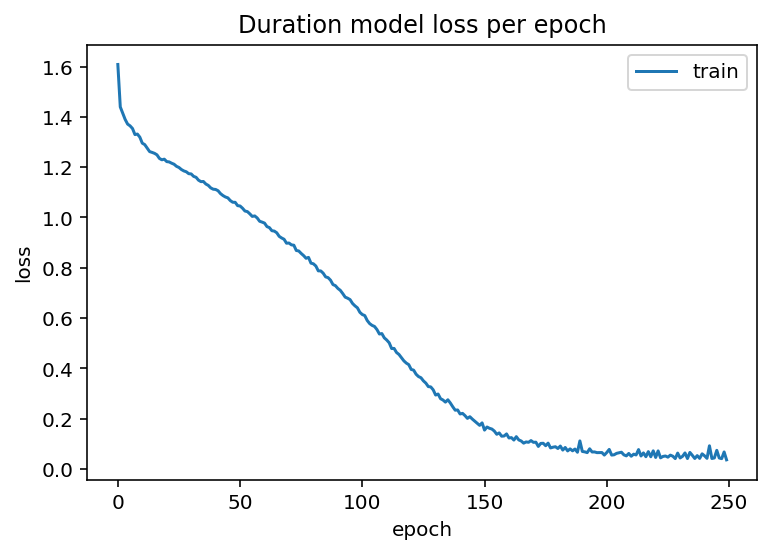

In [10]:
def plotLoss(history, name):
    pyplot.plot(history.history['loss'])
    pyplot.title(name + " loss per epoch")
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper right')
    pyplot.show()
    
plotLoss(noteModelHistory, "Note model")
plotLoss(durationModelHistory, "Duration model")

## Create prediction
The network has now reached a point where predictions can be made, and in turn, new music genearted. 

In [28]:
def predictFeature(feature, model, length):
    # Take a random sequence from the training data
    tempPrediction = feature[np.random.randint(0, len(feature)-1)]
    generated = []
    for i in range(200):
        # Make a prediction
        prediction_input = np.reshape(tempPrediction, (1, len(tempPrediction), 1))
        guess = model.predict(prediction_input, verbose=0)
        result = np.argmax(guess)
        # Add the new prediced feature and snip the temp array
        tempPrediction = np.append(tempPrediction, result)
        tempPrediction = tempPrediction[1:]
        # Append prediction to return array
        generated.append(result)
    return generated
        
notePredictionsRaw = predictFeature(xNote, noteModel, 200)
durationPredictionsRaw = predictFeature(xDuration, durationModel, 200)

## Reverse encoding
In order to retrieve the name of the notes which have been predicted by the network, reversal of the one-hot-encoding is needed. Below two functions are created, one for reversing the one hot encoded dictionaries, and one which loops through each note in the predictions, reversing the encoding:

In [29]:
def reverseDict(thisDict):
    return {v: k for k, v in thisDict.items()}

def decodePredictions(predictions, thisDict):
    decodedPredictions = []
    invDict = reverseDict(thisDict)
    for thisPrediction in predictions:
        decodedPredictions.append(invDict[thisPrediction])
    return decodedPredictions

notePredictions = decodePredictions(notePredictionsRaw, noteDict)
durationPredictions = decodePredictions(durationPredictionsRaw, durationDict)

## Check the score
Now the generated notes and durations can be printed out in order to ensure no strange results have been created:

In [30]:
print(notePredictions)
print(durationPredictions)

['C#5', 'D5', 'B4', 'C5', 'B-4', 'A4', 'A4', 'D5', 'F5', 'E5', 'G5', 'F5', 'E5', 'D5', 'F5', 'E5', 'F5', 'D5', 'E5', 'D5', 'C5', 'B4', 'C5', 'A5', 'G5', 'F#5', 'G5', 'B-5', 'C#5', 'D5', 'D5', 'B4', 'C#5', 'D5', 'C5', 'B-4', 'A4', 'D4', 'G4', 'A4', 'C5', 'B-4', 'C5', 'E-5', 'D5', 'F#5', 'A5', 'G5', 'A5', 'B-5', 'C#5', 'D5', 'D4', 'A4', 'F4', 'D4', 'C#4', 'D4', 'E4', 'F4', 'G4', 'F4', 'E4', 'D4', 'E4', 'F4', 'G4', 'A4', 'A3', 'B3', 'C4', 'A3', 'F4', 'B3', 'E4', 'F4', 'E4', 'D4', 'E4', 'F#4', 'G4', 'F4', 'E4', 'D4', 'E4', 'F4', 'D4', 'G4', 'G4', 'G4', 'E4', 'D4', 'C#4', 'D4', 'G4', 'C4', 'F4', 'E4', 'F4', 'G#3', 'E4', 'D4', 'C4', 'D4', 'F4', 'E4', 'D4', 'C4', 'D4', 'A4', 'F4', 'D4', 'C#4', 'D4', 'D4', 'F4', 'G4', 'F4', 'E4', 'D4', 'G4', 'E4', 'F4', 'E4', 'A4', 'F#4', 'G4', 'F#4', 'D5', 'G#4', 'A4', 'A3', 'C4', 'A3', 'D4', 'F4', 'E4', 'D4', 'C4', 'A4', 'D4', 'E4', 'A4', 'G4', 'F4', 'E4', 'D4', 'D4', 'G4', 'G4', 'C4', 'A3', 'B-3', 'A3', 'F3', 'G3', 'C4', 'A3', 'B3', 'E4', 'C#4', 'D4', 'G4',

## Generate Score
The next step is to convert the two arrays into a music21 score in order to eventually convert them into MIDI. Below a function takes in the generated notes and durations and outputs a score. An organ voice is chosen for the piece:

In [31]:
def generateScore(genNotes, genDurs):
    generatedScore = stream.Score()
    mainPart = stream.Part()
    for i in range(len(genNotes)):
        thisNote = note.Note(genNotes[i])
        thisNote.duration.quarterLength=float(genDurs[i])
        mainPart.append(thisNote)
    mainPart.insert(0, instrument.Organ())
    generatedScore.insert(0, mainPart)
    return generatedScore

generatedScore = generateScore(notePredictions, durationPredictions)

## Visualise Score
Before writing the score to file, first it is visualised to ensure conversion occured correctly:

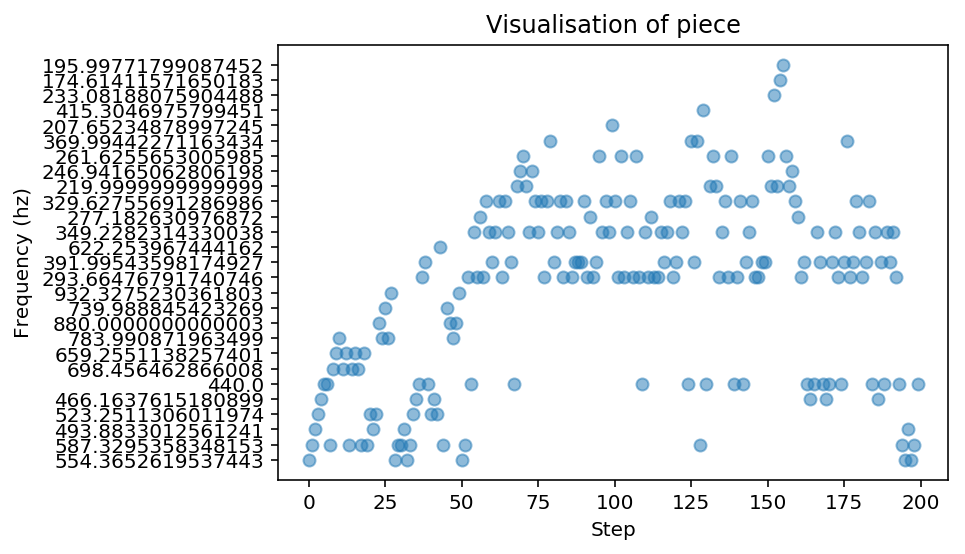

In [32]:
generatedFreqArray = createFreqArray(generatedScore)
visualiseFreqArray(generatedFreqArray)

## Write Score to MIDI file
And finally the score is written to the file `generated.mid`:

In [33]:
generatedScore.write("midi", "generated.mid")

'generated.mid'

## Conversion to wav, then mp3
In order to play the midi file it needs to be converted to wav, then finally mp3. Ways of doing this vary depending on platform. On Linux, the following command was used:

`wildmidi generated.mid --wavout=generated.wav` 

then

`yes |  ffmpeg -i generated.wav generated.mp3`

(with yes preventing ffmpeg expecting input from the terminal)

and finally removing the wav file

`rm generated.wav`

In [6]:
def midiToWav(filename):
    cmd = "wildmidi "+filename+".mid --wavout="+filename+".wav"
    print(os.popen(cmd).read())
    cmd = "yes | ffmpeg -i "+filename+".wav "+filename+".mp3"
    print(os.popen(cmd).read())
    cmd = "rm "+filename+".wav"
    print(os.popen(cmd).read())
    
midiToWav("generated")


WildMidi 0.4.0 Open Source Midi Sequencer
Copyright (C) WildMIDI Developers 2001-2016

WildMidi comes with ABSOLUTELY NO WARRANTY
This is free software, and you are welcome to redistribute it under
the terms and conditions of the GNU General Public License version 3.
For more information see COPYING

Report bugs to https://github.com/Mindwerks/wildmidi/issues
WildMIDI homepage is at http://www.mindwerks.net/projects/wildmidi/

Initializing Sound System
Initializing libWildMidi 0.4.0

 +  Volume up        e  Better resampling    n  Next Midi
 -  Volume down      l  Log volume           q  Quit
 ,  1sec Seek Back   r  Reverb               .  1sec Seek Forward
 m  save as midi     p  Pause On/Off


Playing generated.mid 
[Approx  1m 28s Total]
Finishing and closing wav output






## Results
*(If the piece won't play, rerun the python code. Ocasionally the player will display 9:17:59, this is just a glitch and should be ignored, alternativly the wav files are available in the notebook directory)*

### Final result
Below is the final piece converted into wav format:

In [7]:
ipd.Audio('generated.mp3') 

### Additional attempt #1
Additional attempts were made prior to the final run of the notebook, an early attempt can be found below:

In [8]:
ipd.Audio('generated-other-1.mp3') 

### Additional attemp #2

In [9]:
ipd.Audio('generated-other-2.mp3') 

## Conclusion

Three pieces of music were generated via an LTSM network trained on one-hot-encoded data generated from  Bach's Contrapunctus I from The Art of Fugue. These three pieces generally stay in key and are Bach-esque, with some interesting original note sequences and duration sequences generated.

However, whilst in the style of Bach, these pieces are often directionless and repetitive. Additionaly, on several occasions certain note sequences are verbatim copies of the original score.

One issue holding the project back was the lack of computation power. It took approximatly 20 minutes to train the network on a single MIDI file; this resulted in my laptop overheating a couple of times. Ideally I would like to try train the network using anywhere between 5-10 pieces of music. This could potentially enable the network to generate  more diverse and interesting pieces. 


Much more work and computation power is required in the future to improve the quality and coherence of the generated music. However, overall, I see this project as a sucess, as the network did manage to generate music resembling the style of Bach.